Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0243
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0047
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0030
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0027
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0020
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0022
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0019
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0020
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0019
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0017
Epoch 11/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0018
Epoch 12/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0013
Epoch 13/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0019
Epoch 14/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0019
Epoch 15/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s

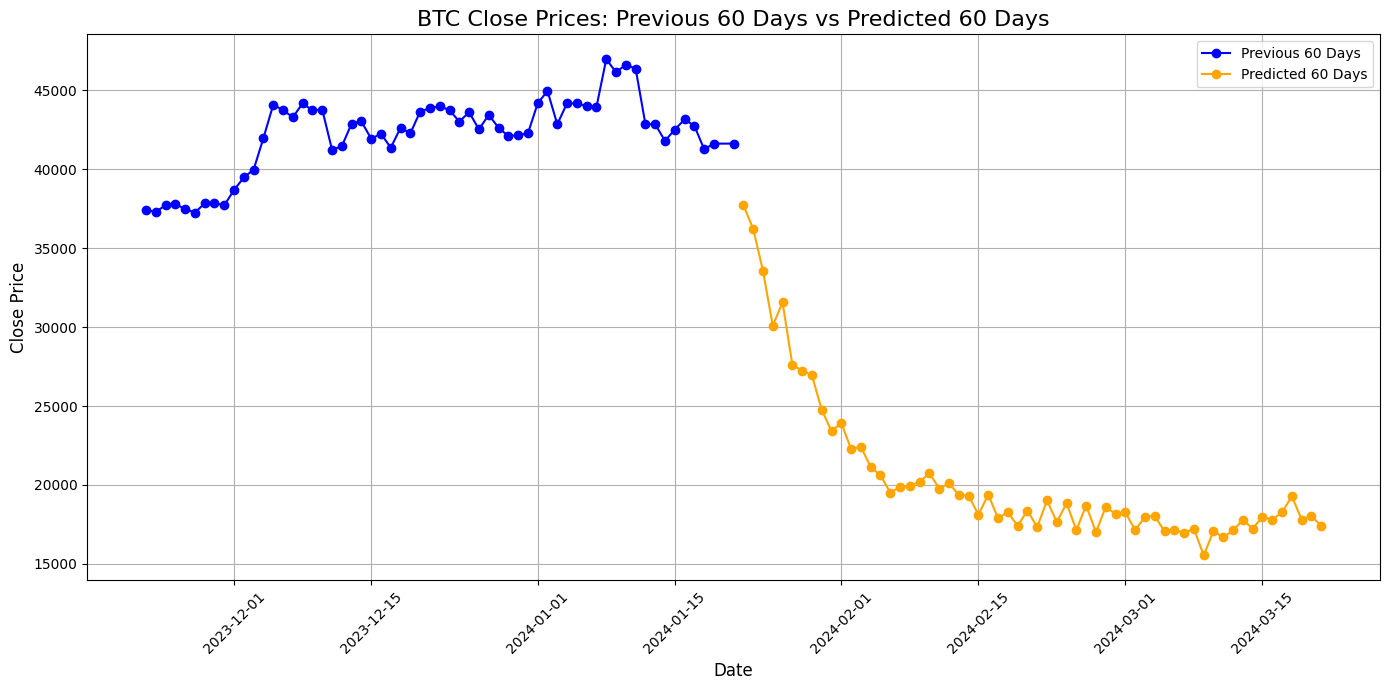

In [ ]:
#lucas ignore
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
import datetime
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the data
data = pd.read_csv('BTC.csv')  # Replace with your CSV file name
data = data[['Date', 'Volume', 'Close']].dropna()  # Keep Date, Volume, and Close columns
data['Date'] = pd.to_datetime(data['Date']).apply(lambda x: x.toordinal())  # Convert Date to ordinal numbers

# Create a copy of the original dataset to keep it unscaled
data_unscaled = data.copy()

# Initialize scalers for Date, Volume, and Close
scaler_date = MinMaxScaler(feature_range=(0, 1))
scaler_volume = MinMaxScaler(feature_range=(0, 1))
scaler_close = MinMaxScaler(feature_range=(0, 1))

# Scale the dataset
data_scaled = data.copy()
data_scaled['Date'] = scaler_date.fit_transform(data[['Date']])
data_scaled['Volume'] = scaler_volume.fit_transform(data[['Volume']])
data_scaled['Close'] = scaler_close.fit_transform(data[['Close']])

# Function to create sequences for LSTM
def create_sequences(data, time_steps=3):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps][-1])  # Target is Close price of the next step
    return np.array(X), np.array(y)

# Combine Date, Volume, and Close into one feature matrix
features = data_scaled[['Date', 'Volume', 'Close']].values
time_steps = 3  # Use the last 3 days to predict the next day
X, y = create_sequences(features, time_steps)

# Reshape input for LSTM (samples, time steps, features)
X = X.reshape(X.shape[0], time_steps, 3)

# Step 2: Define the LSTM model
def build_close_model():
    model = Sequential([
        Input(shape=(time_steps, 3)),  # 3 features: Date, Volume, Close
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        BatchNormalization(),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)  # Predict Close price
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    return model

model_close = build_close_model()

# Step 3: Train the model
model_close.fit(X, y, epochs=50, batch_size=32, verbose=1)

# Step 4: Predict and retrain for the next 60 days
for day in range(1, 61):
    # Get the most recent 3 days of data
    recent_data = data_unscaled.tail(time_steps).copy()
    next_date = recent_data['Date'].max() + 1  # Increment date by 1 day

    # Scale the recent data
    recent_data_scaled = recent_data.copy()
    recent_data_scaled['Date'] = scaler_date.transform(recent_data[['Date']])
    recent_data_scaled['Volume'] = scaler_volume.transform(recent_data[['Volume']])
    recent_data_scaled['Close'] = scaler_close.transform(recent_data[['Close']])

    # Prepare the input for the LSTM model
    next_input = recent_data_scaled[['Date', 'Volume', 'Close']].values.reshape(1, time_steps, 3)

    # Predict the Close price
    predicted_close_scaled = model_close.predict(next_input).flatten()[0]
    predicted_close_unscaled = scaler_close.inverse_transform([[predicted_close_scaled]])[0][0]

    # Use the most recent Volume for the new day's input
    most_recent_volume = recent_data['Volume'].iloc[-1]

    # Add the new prediction to the unscaled dataset
    new_row = pd.DataFrame({'Date': [next_date], 'Volume': [most_recent_volume], 'Close': [predicted_close_unscaled]})
    data_unscaled = pd.concat([data_unscaled, new_row], ignore_index=True)

    # Update the scaled dataset (sync both DataFrames)
    data_scaled = data_unscaled.copy()
    data_scaled['Date'] = scaler_date.fit_transform(data_unscaled[['Date']])
    data_scaled['Volume'] = scaler_volume.fit_transform(data_unscaled[['Volume']])
    data_scaled['Close'] = scaler_close.fit_transform(data_unscaled[['Close']])

    # Create new sequences for retraining
    features = data_scaled[['Date', 'Volume', 'Close']].values
    X, y = create_sequences(features, time_steps)

    # Retrain the model
    X = X.reshape(X.shape[0], time_steps, 3)
    model_close.fit(X, y, epochs=1, batch_size=32, verbose=0)

    # Print the predicted Close price for this day
    print(f"Day {day}: Predicted Close for {datetime.date.fromordinal(int(next_date))}: {predicted_close_unscaled}")

# Step 5: Plot the predictions
# Extract the last 60 days (predicted) and previous 60 days
predicted_60_days = data_unscaled.tail(60).copy()
previous_60_days = data_unscaled.iloc[-120:-60].copy()

# Convert Date back to readable format
predicted_60_days['Date'] = predicted_60_days['Date'].apply(lambda x: datetime.date.fromordinal(int(x)))
previous_60_days['Date'] = previous_60_days['Date'].apply(lambda x: datetime.date.fromordinal(int(x)))

# Plot the comparison graph
plt.figure(figsize=(14, 7))

# Previous 60 days
plt.plot(previous_60_days['Date'], previous_60_days['Close'], marker='o', color='blue', label='Previous 60 Days')

# Predicted 60 days
plt.plot(predicted_60_days['Date'], predicted_60_days['Close'], marker='o', color='orange', label='Predicted 60 Days')

plt.title('BTC Close Prices: Previous 60 Days vs Predicted 60 Days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import datetime

# Step 1: Load the BTC data (10 years of data)
btc_data = pd.read_csv('BTC.csv')  # Replace with your actual file name
btc_data = btc_data[['Date', 'Volume', 'Close']].dropna()

# Convert 'Date' to ordinal for easier processing
btc_data['Date'] = pd.to_datetime(btc_data['Date']).apply(lambda x: x.toordinal())

# Step 2: Scaling the data
scaler_date = MinMaxScaler(feature_range=(0, 1))
scaler_volume = MinMaxScaler(feature_range=(0, 1))
scaler_close = MinMaxScaler(feature_range=(0, 1))

btc_data['Date'] = scaler_date.fit_transform(pd.DataFrame(btc_data['Date'], columns=['Date']))
btc_data['Volume'] = scaler_volume.fit_transform(pd.DataFrame(btc_data['Volume'], columns=['Volume']))
btc_data['Close'] = scaler_close.fit_transform(pd.DataFrame(btc_data['Close'], columns=['Close']))

# Step 3: Create training data
def create_training_data(data):
    X, y = [], []
    for i in range(1, len(data)):
        X.append([data.iloc[i, 0], data.iloc[i, 1], data.iloc[i - 1, 2]])  # Date, Volume, Previous Close
        y.append(data.iloc[i, 2])  # Target: Current day's Close
    return np.array(X), np.array(y)

# Prepare training data
X_train, y_train = create_training_data(btc_data)

# Reshape X for LSTM input: (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

# Step 4: Build and train the LSTM model
def build_model():
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(1, X_train.shape[2])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)  # Predict Close price
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')
    return model

model = build_model()

# Add EarlyStopping for stability
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, callbacks=[early_stop])

# Step 5: Predict the Close price for 60 days
btc_data_unscaled = pd.read_csv('BTC.csv')  # Reload to get original unscaled data
btc_data_unscaled = btc_data_unscaled[['Date', 'Volume', 'Close']].dropna()
btc_data_unscaled['Date'] = pd.to_datetime(btc_data_unscaled['Date']).dt.date

# Use the most recent Close price as the initial "previous close"
previous_close = btc_data['Close'].iloc[-1]

for day in range(1, 61):  # Loop for 60 days
    # Find the most recent date
    last_date = btc_data_unscaled['Date'].max()
    next_date_datetime = last_date + datetime.timedelta(days=1)

    # Simulate the next volume (from volume predictions, here use random values for simplicity)
    next_volume = np.random.random()  # Replace with actual predicted volumes

    # Scale the inputs
    next_date_scaled = scaler_date.transform(pd.DataFrame([[next_date_datetime.toordinal()]], columns=['Date']))[0][0]
    next_volume_scaled = scaler_volume.transform(pd.DataFrame([[next_volume]], columns=['Volume']))[0][0]

    # Prepare the input for the model
    next_input = np.array([[next_date_scaled, next_volume_scaled, previous_close]])
    next_input = next_input.reshape((1, 1, 3))  # Reshape for LSTM

    # Predict the Close price
    predicted_close_scaled = model.predict(next_input).flatten()[0]
    predicted_close_unscaled = scaler_close.inverse_transform(pd.DataFrame([[predicted_close_scaled]], columns=['Close']))[0][0]

    # Add the predicted row to the dataset
    new_row = {
        'Date': next_date_datetime,
        'Volume': next_volume,
        'Close': predicted_close_unscaled
    }
    new_row_df = pd.DataFrame([new_row])
    btc_data_unscaled = pd.concat([btc_data_unscaled, new_row_df], ignore_index=True)

    # Update previous_close for the next prediction
    previous_close = scaler_close.transform(pd.DataFrame([[predicted_close_unscaled]], columns=['Close']))[0][0]

    # Rescale the dataset for retraining
    btc_data_updated = btc_data_unscaled.copy()
    btc_data_updated['Date'] = btc_data_updated['Date'].apply(lambda x: x.toordinal())
    btc_data_updated['Date'] = scaler_date.fit_transform(pd.DataFrame(btc_data_updated['Date'], columns=['Date']))
    btc_data_updated['Volume'] = scaler_volume.fit_transform(pd.DataFrame(btc_data_updated['Volume'], columns=['Volume']))
    btc_data_updated['Close'] = scaler_close.fit_transform(pd.DataFrame(btc_data_updated['Close'], columns=['Close']))

    # Retrain the model
    X_train, y_train = create_training_data(btc_data_updated)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)  # Retrain with the updated dataset

    # Print progress
    print(f"Day {day}: Predicted Close for {next_date_datetime}: {predicted_close_unscaled}")

# Step 6: Print final dataset (human-readable format)
btc_data_human_readable = btc_data_unscaled.copy()

print("\nFinal dataset (last 10 rows):")
print(btc_data_human_readable.tail(10))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1456
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0317
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0174
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0158
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0143
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0137
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0132
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0125
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0128
Epoch 11/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121
Epoch 12/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0120
Epoch 13/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115
Epoch 14/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0120
Epoch 15/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

Epoch 1/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0028
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017
Epoch 5/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022
Epoch 6/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014
Epoch 7/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017
Epoch 8/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016
Epoch 9/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017
Epoch 10/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 11/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 12/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020
Epoch 13/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015
Epoch 14/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015
Epoch 15/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

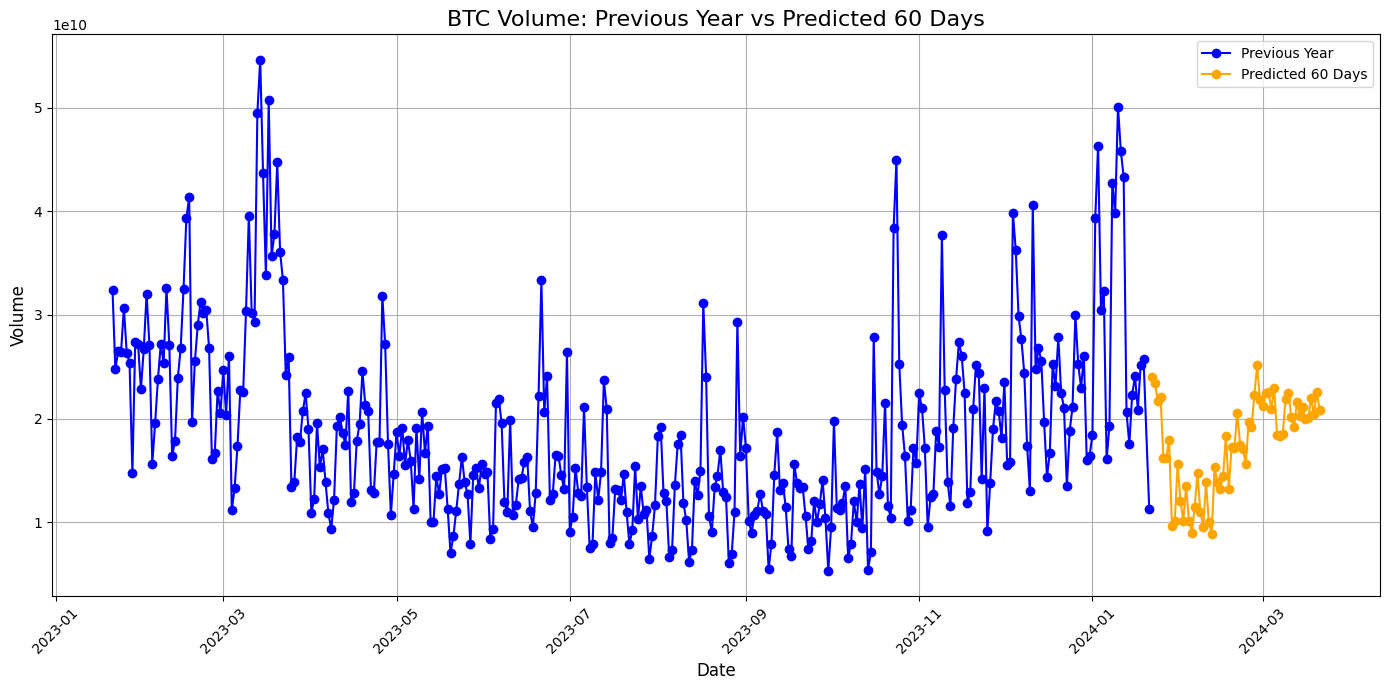

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
import datetime
import matplotlib.pyplot as plt

# Step 1: Load and preprocess the data
data = pd.read_csv('BTC.csv')  # Replace with your CSV file name
data = data[['Date', 'Volume']].dropna()  # Keep only Date and Volume columns, and drop NaN values
data['Date'] = pd.to_datetime(data['Date']).apply(lambda x: x.toordinal())  # Convert Date to ordinal numbers

# Create a copy of the original dataset to keep it unscaled
data_unscaled = data.copy()

# Initialize scalers for date and volume
scaler_date = MinMaxScaler(feature_range=(0, 1))
scaler_volume = MinMaxScaler(feature_range=(0, 1))

# Scale the Date and Volume columns for model training
scaled_data = data.copy()
scaled_data['Date'] = scaler_date.fit_transform(data[['Date']])
scaled_data['Volume'] = scaler_volume.fit_transform(data[['Volume']])

# Prepare data for the LSTM model
X = scaled_data['Date'].values.reshape(-1, 1, 1)  # Reshape for LSTM: (samples, time steps, features)
y = scaled_data['Volume'].values  # Target values

# Define the LSTM model
def build_volume_model():
    model = Sequential([
        Input(shape=(1, 1)),  # Explicitly specify input shape
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(20, return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

model_volume = build_volume_model()

# Train the model
model_volume.fit(X, y, epochs=30, batch_size=32, verbose=1)

# Loop to predict and retrain for 60 days
for day in range(1, 61):
    # Predict the volume for the next day
    most_recent_date = data_unscaled['Date'].max()  # Most recent unscaled date in the data
    next_date = most_recent_date + 1  # Next ordinal date

    # Scale the next date
    next_date_scaled = scaler_date.transform(pd.DataFrame({'Date': [next_date]}))  # Scale the next date
    next_date_scaled = next_date_scaled.reshape(1, 1, 1)  # Reshape for LSTM input

    predicted_volume_scaled = model_volume.predict(next_date_scaled).flatten()[0]
    predicted_volume_unscaled = scaler_volume.inverse_transform([[predicted_volume_scaled]])[0][0]

    # Add the predicted date and volume to the original (unscaled) dataset
    new_row = pd.DataFrame({'Date': [next_date], 'Volume': [predicted_volume_unscaled]})
    data_unscaled = pd.concat([data_unscaled, new_row], ignore_index=True)

    # Prepare the updated dataset for retraining
    scaled_data = data_unscaled.copy()
    scaled_data['Date'] = scaler_date.fit_transform(data_unscaled[['Date']])
    scaled_data['Volume'] = scaler_volume.fit_transform(data_unscaled[['Volume']])

    # Prepare the updated training data
    X = scaled_data['Date'].values.reshape(-1, 1, 1)
    y = scaled_data['Volume'].values

    # Retrain the model with the updated dataset
    model_volume.fit(X, y, epochs=1, batch_size=32, verbose=0)

    # Output the predicted volume for this day
    print(f"Day {day}: Predicted Volume for {datetime.date.fromordinal(int(next_date))}: {predicted_volume_unscaled}")

# Extract the previous year's data (365 days before predictions)
previous_year = data_unscaled.iloc[-425:-60].copy()  # Adjust the range for ~365 days before predictions

# Extract the predicted 60 days
predicted_60_days = data_unscaled.tail(60).copy()

# Convert ordinal dates back to readable format for plotting
previous_year['Date'] = previous_year['Date'].apply(lambda x: datetime.date.fromordinal(int(x)))
predicted_60_days['Date'] = predicted_60_days['Date'].apply(lambda x: datetime.date.fromordinal(int(x)))

# Plot the previous year and predicted 60 days
plt.figure(figsize=(14, 7))

# Plot previous year's data
plt.plot(previous_year['Date'], previous_year['Volume'], marker='o', color='blue', label='Previous Year')

# Plot predicted 60 days
plt.plot(predicted_60_days['Date'], predicted_60_days['Volume'], marker='o', color='orange', label='Predicted 60 Days')

# Add titles and labels
plt.title('BTC Volume: Previous Year vs Predicted 60 Days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()



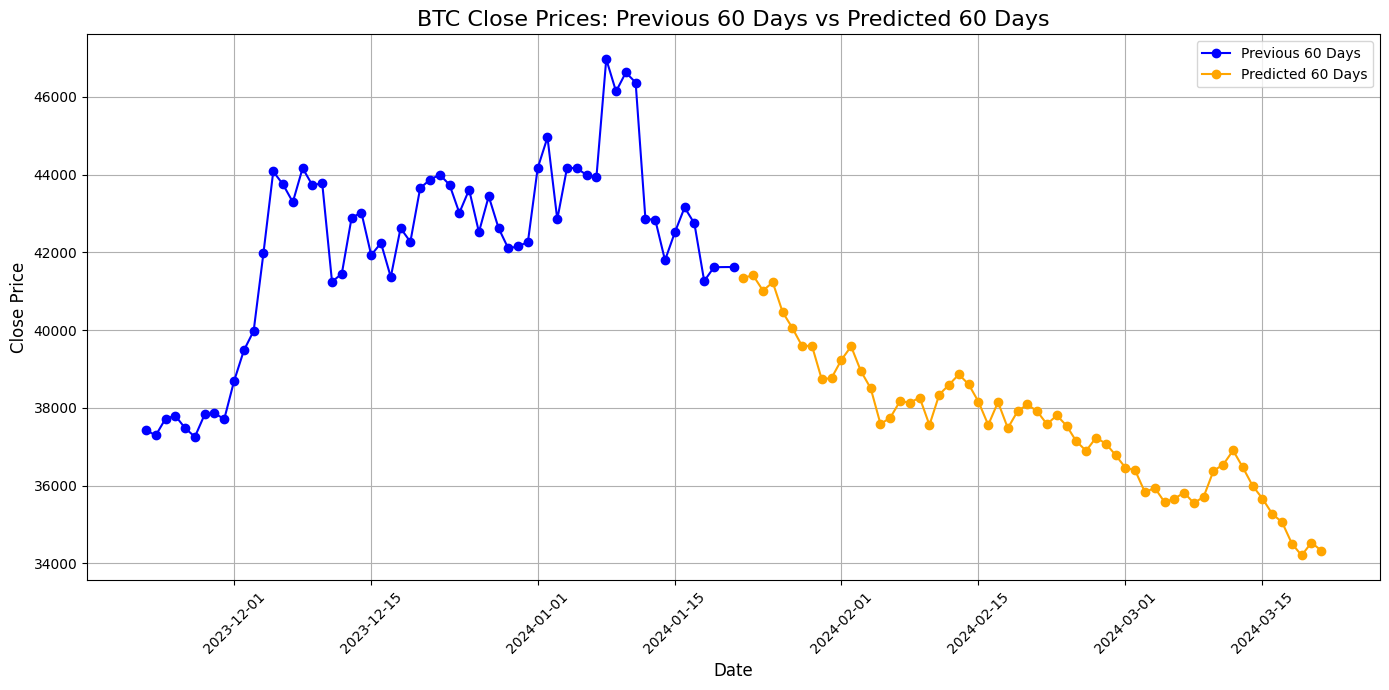

In [ ]:
# Step 7: Extract and plot the previous 60 days and predicted 60 days
# Convert the final unscaled dataset's Date back to datetime for plotting
btc_data_unscaled['Date'] = btc_data_unscaled['Date'].apply(lambda x: x if isinstance(x, datetime.date) else datetime.date.fromordinal(int(x)))

# Extract the previous 60 days (before predictions)
previous_60_days = btc_data_unscaled.iloc[-120:-60].copy()  # Adjust this range if needed

# Extract the predicted 60 days (last 60 rows)
predicted_60_days = btc_data_unscaled.iloc[-60:].copy()

# Plot the comparison
plt.figure(figsize=(14, 7))

# Plot previous 60 days
plt.plot(previous_60_days['Date'], previous_60_days['Close'], marker='o', color='blue', label='Previous 60 Days')

# Plot predicted 60 days
plt.plot(predicted_60_days['Date'], predicted_60_days['Close'], marker='o', color='orange', label='Predicted 60 Days')

# Add titles and labels
plt.title('BTC Close Prices: Previous 60 Days vs Predicted 60 Days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


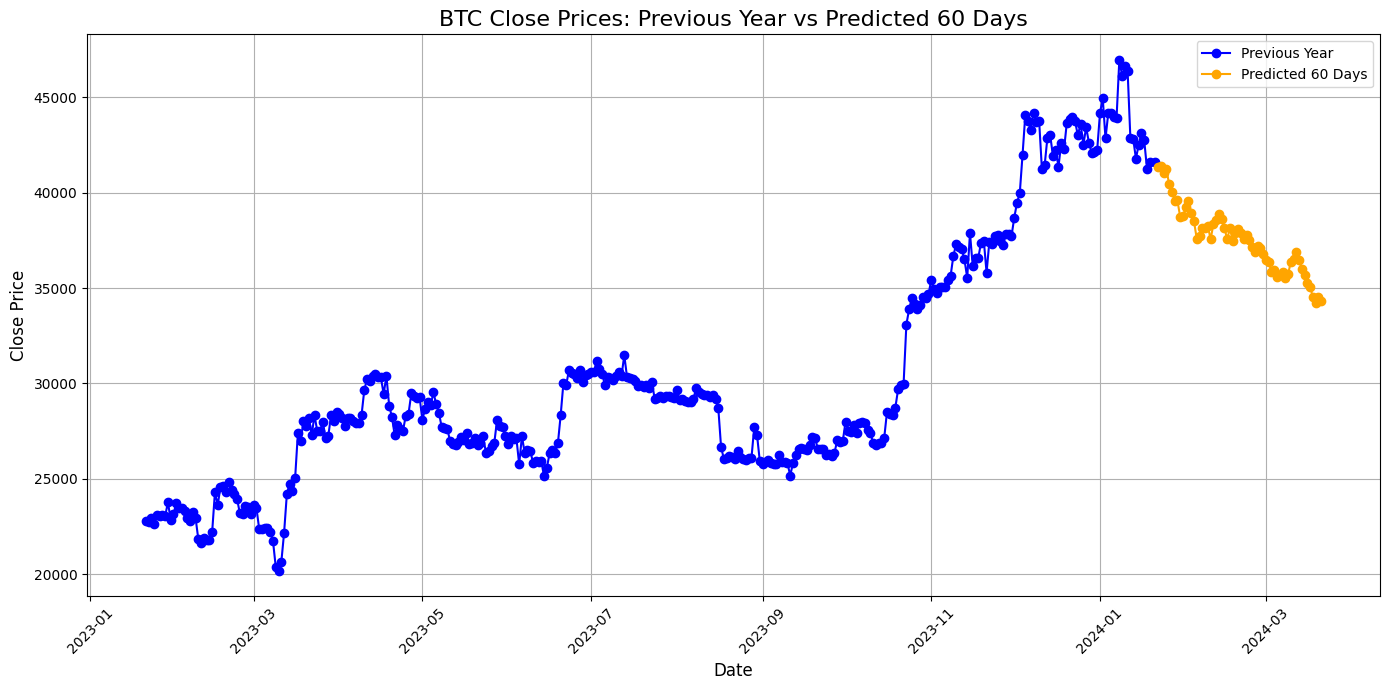

In [ ]:
# Step 7: Extract and plot the previous year and predicted 60 days
# Ensure all dates are in datetime format
btc_data_unscaled['Date'] = btc_data_unscaled['Date'].apply(lambda x: x if isinstance(x, datetime.date) else datetime.date.fromordinal(int(x)))

# Extract the previous year's data (last 365 rows before predictions)
previous_year = btc_data_unscaled.iloc[-425:-60].copy()  # Adjusted range to cover approximately a year

# Extract the predicted 60 days (last 60 rows)
predicted_60_days = btc_data_unscaled.iloc[-60:].copy()

# Plot the comparison
plt.figure(figsize=(14, 7))

# Plot previous year
plt.plot(previous_year['Date'], previous_year['Close'], marker='o', color='blue', label='Previous Year')

# Plot predicted 60 days
plt.plot(predicted_60_days['Date'], predicted_60_days['Close'], marker='o', color='orange', label='Predicted 60 Days')

# Add titles and labels
plt.title('BTC Close Prices: Previous Year vs Predicted 60 Days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


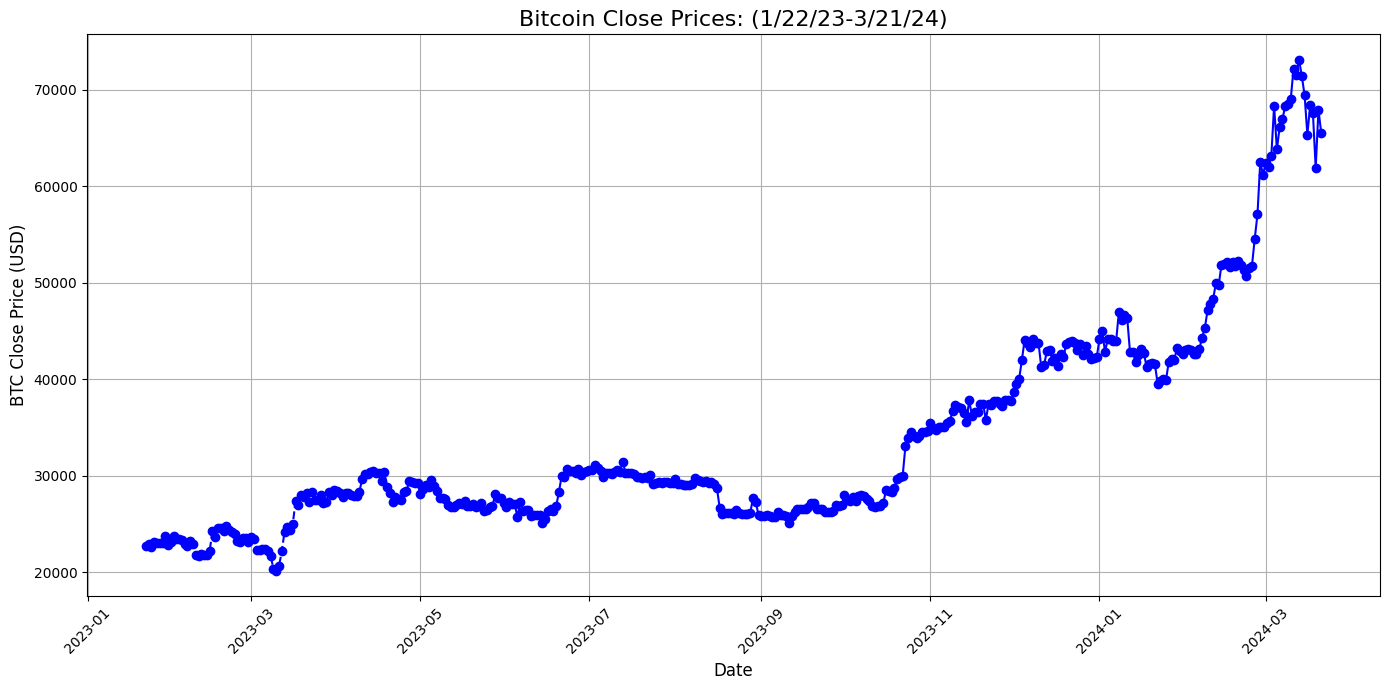

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Step 1: Load the data from the Excel file
btc_data = pd.read_excel('temp.xlsx', header=None)

# Assign column names based on your data structure
btc_data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Convert the 'Date' column to datetime format
btc_data['Date'] = pd.to_datetime(btc_data['Date'])

# Step 2: Extract and plot the previous year and predicted 60 days
# Ensure all dates are in datetime format (already done in Step 1)
btc_data['Date'] = btc_data['Date'].apply(
    lambda x: x if isinstance(x, datetime.date) else x.date()
)

# Extract the previous year's data (approximately 365 rows)
previous_year = btc_data.iloc[-425:-60].copy()

# Extract the predicted 60 days (last 60 rows)
predicted_60_days = btc_data.iloc[-60:].copy()

# Step 3: Plot the comparison
plt.figure(figsize=(14, 7))

# Plot previous year and predicted 60 days in blue
plt.plot(previous_year['Date'], previous_year['Close'], marker='o', color='blue')
plt.plot(predicted_60_days['Date'], predicted_60_days['Close'], marker='o', color='blue', linestyle='--')

# Add titles and labels
plt.title('Bitcoin Close Prices: (1/22/23-3/21/24)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('BTC Close Price (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjust layout for better spacing

# Show the plot
plt.show()


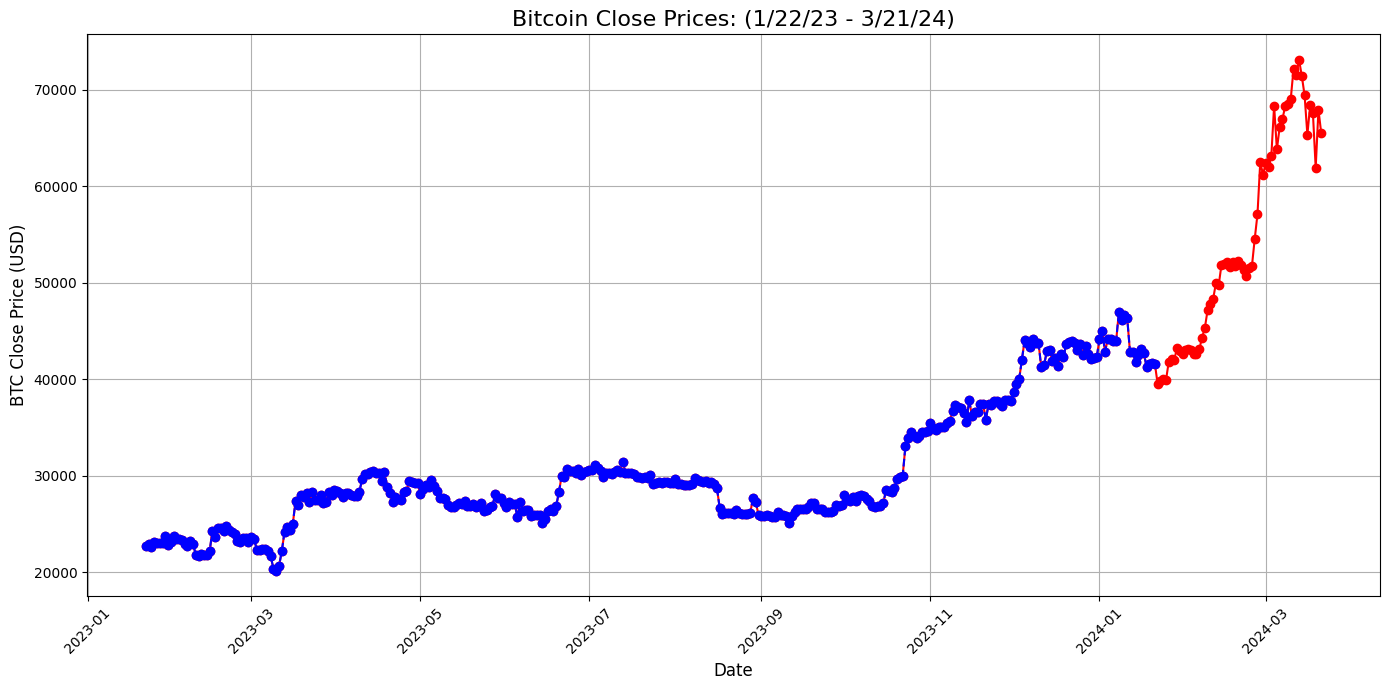

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Step 1: Load the data from the Excel file
btc_data = pd.read_excel('temp.xlsx', header=None)

# Assign column names based on your data structure
btc_data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Convert the 'Date' column to datetime format
btc_data['Date'] = pd.to_datetime(btc_data['Date'])

# Step 2: Extract data ranges
previous_year = btc_data.iloc[-425:].copy()  # Full data from the past year
final_60_days = previous_year.iloc[-365:].copy()  # Final 60 days from the last year

# Step 3: Plot the comparison
plt.figure(figsize=(14, 7))

# Plot the entire previous year in blue
plt.plot(previous_year['Date'], previous_year['Close'], marker='o', color='red')

# Highlight the final 60 days in red
plt.plot(final_60_days['Date'], final_60_days['Close'], marker='o', color='blue', linestyle='--')

# Add titles and labels
plt.title('Bitcoin Close Prices: (1/22/23 - 3/21/24)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('BTC Close Price (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
